In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
import pandas as pd
import os.path

plt.style.use('seaborn')


In [143]:
#install pytrends
!pip install pytrends


In [144]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [145]:
covid_europe = pd.read_csv("../data_source/covid_europe.csv")

In [146]:
covid_europe.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,life_expectancy,surface_area,population,employment_industry,internet_users,iso2
0,Austria,2020-02-25,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
1,Austria,2020-02-26,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
2,Austria,2020-02-27,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
3,Austria,2020-02-28,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
4,Austria,2020-02-29,9.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT


In [147]:
covid_europe["date"] = pd.to_datetime( covid_europe["date"] )

In [148]:
covid_europe = covid_europe.sort_values( ["location","date"] , ascending=True )

## Preguntas de negocio:

 - Segun se inicio el proceso de vacunas que cambio hugo en el comportamiento de nuevos casos, y nuevos deaths?
 - Segun el inicio de aplicacion de vacunas mensual como se compara con los nuevos casos.
 - Que tipo de score podriamos asignar a cada pais segun el mes para evaluar el nivel progreso
 


## Analisis descriptivo

- Por pais y mes como esta la mediana y la media de nuevos casos y nuevas muertes una ves se haya iniciado el proceso de vacunas

Para iniciar este analisis comencemos excluyendo los meses donde no se tenia la informacion de vacunas, se realizara mediante la suma acumulada para no eliminar dias en el que tal ves hayan zero vacunas

In [149]:
covid_vaccine = covid_europe.loc[ covid_europe.total_vaccinations > 0 , : ].copy()

In [150]:
covid_vaccine["yearMonth"] = covid_vaccine['date'].dt.to_period('M')

In [151]:
covid_vaccine["yearMonth"] = covid_vaccine.apply( lambda r: "{0}-01".format( r["yearMonth"] ) ,axis=1 )

In [152]:
first_summary = covid_vaccine.groupby(["location","yearMonth"],as_index=False).agg({"new_cases":["mean","median"],"new_deaths":["mean","median"]})

In [153]:
first_summary["yearMonth"] = pd.to_datetime( first_summary["yearMonth"] )

In [154]:
first_summary.columns = first_summary.columns.droplevel(0)

In [155]:
first_summary.columns = ['location','yearMonth','new_cases_mean','new_cases_median','new_deaths_mean','new_deaths_median']

In [156]:
first_summary["location"].drop_duplicates()

0             Austria
14            Belgium
28           Bulgaria
42            Croatia
56             Cyprus
69            Czechia
83            Denmark
97            Estonia
111            France
125           Hungary
137           Ireland
151             Italy
165            Latvia
179         Lithuania
193        Luxembourg
207             Malta
220            Norway
234            Poland
248          Portugal
262            Serbia
275          Slovenia
289             Spain
302       Switzerland
316    United Kingdom
Name: location, dtype: object

In [213]:
def plot_two_lines( dataset , country , date , y1 , y2 , y1_label , y2_label , title ):
    c_ = country
    to_plot = dataset.loc[ dataset['location'] == c_ , : ]

    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()
    ax.set_title(title)    
    ax.plot(to_plot[date], to_plot[y1], color='blue', marker='x')
    ax2.plot(to_plot[date], to_plot[y2], color='red', marker='o')
    ax.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    ax.legend([y1_label])
    ax2.legend([y2_label], loc='upper center')
    ax.set_xticks(to_plot[date].dt.date)
    ax.set_xticklabels(to_plot[date], rotation=90)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    plt.tight_layout()
    plt.show()

In [237]:
def find_trend( dataset ,country ):
    
    min_date = np.min(dataset.loc[  first_summary["location"] == country  ,  "yearMonth" ])
    max_date = np.max(dataset.loc[  first_summary["location"] == country  ,  "yearMonth" ])
    
    geo_ = covid_vaccine.loc[ covid_vaccine['location'] == country , ["iso2"]  ].drop_duplicates().iloc[0,0]   
        
    #historical interest
    
    if( os.path.isfile("../data_source/trend_{0}.csv".format(country)) ):
        historicaldf = pd.read_csv("../data_source/trend_{0}.csv".format(country))
        historicaldf["date"] = pd.to_datetime( historicaldf["date"] )
    else:
        historicaldf = pytrend.get_historical_interest(
            ['Covid']
            , year_start = min_date.year, month_start =min_date.month, day_start =min_date.day, hour_start =0
            , year_end   = max_date.year, month_end   =max_date.month, day_end   =max_date.day, hour_end   =0
            , cat=0
            , geo=geo_
            , gprop=''
            , sleep=0
        )    
        historicaldf.to_csv("../data_source/trend_{0}.csv".format(country))

    #visualise
    #plot a timeseries chart
    
    historicaldf["date"] = historicaldf['date'].dt.to_period('M')
    historicaldf["date"] = historicaldf.apply( lambda r: "{0}-01".format( r["date"] ) ,axis=1 )
    historicaldf = historicaldf.groupby(["date"],as_index=False).agg({"Covid":["median",]})
    historicaldf["date"] = pd.to_datetime( historicaldf["date"] )
    
    
    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()
    ax.set_title("Tendencia de la palabra COVID atraves del  tiempo")    
    ax.plot(historicaldf["date"], historicaldf["Covid"], color='blue', marker='x')    
    ax.set_ylabel("Popularidad")
    ax.legend(["Popularidad"])

    ax.set_xticklabels(historicaldf["date"], rotation=90)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    
    plt.tight_layout()
    plt.show()

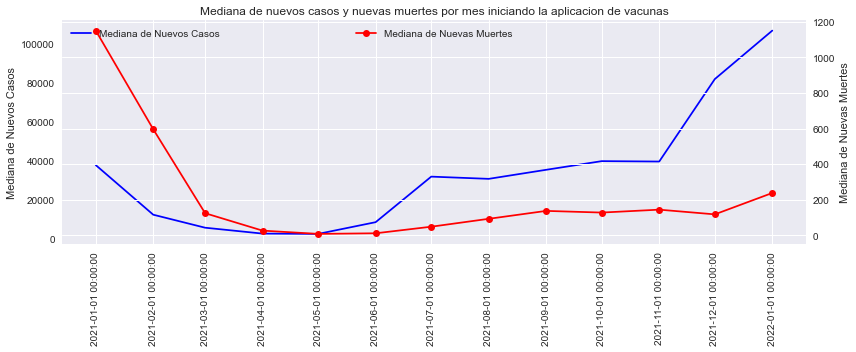

In [238]:
plot_two_lines(first_summary , "United Kingdom" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-237-ebba84a61a8b>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


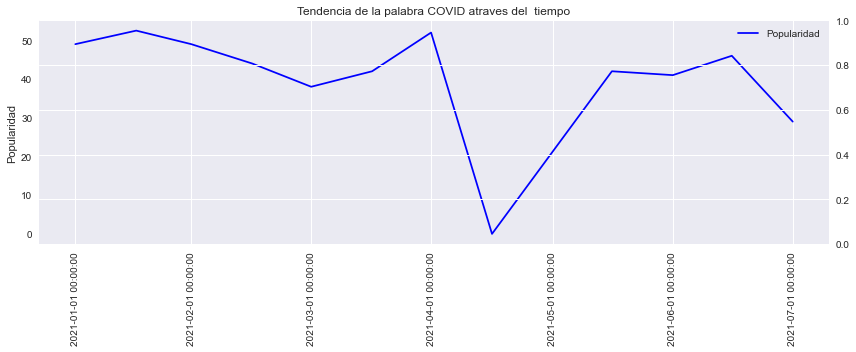

In [239]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "United Kingdom" ) 

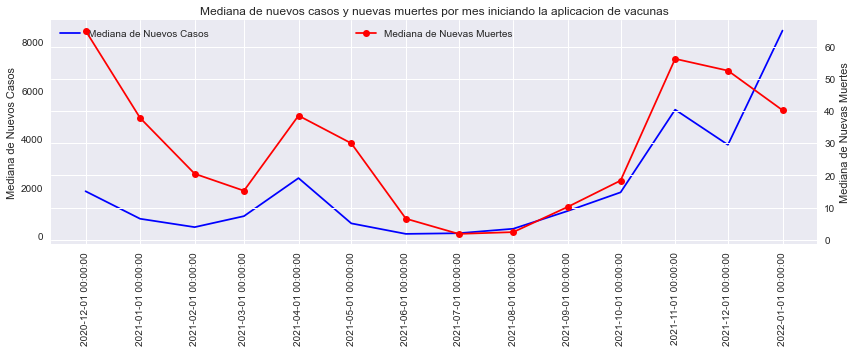

In [240]:
plot_two_lines(first_summary , "Croatia" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-237-ebba84a61a8b>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


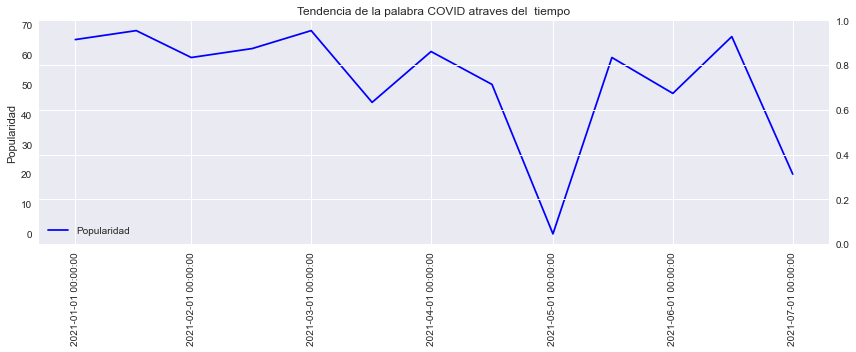

In [241]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "Croatia" ) 

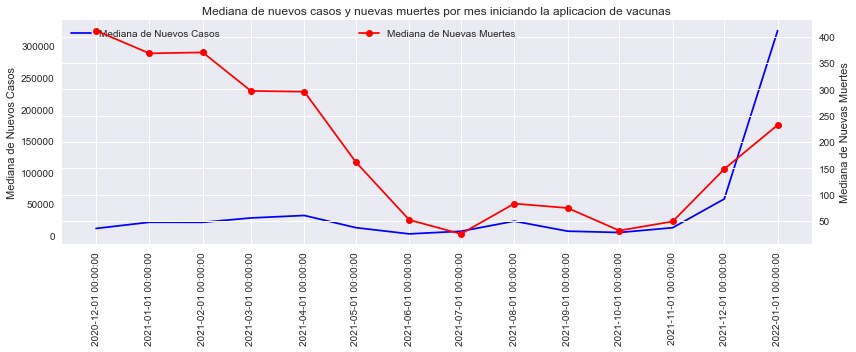

In [242]:
plot_two_lines(first_summary , "France" , "yearMonth" , "new_cases_median" , "new_deaths_mean" , "Mediana de Nuevos Casos" , "Mediana de Nuevas Muertes" , "Mediana de nuevos casos y nuevas muertes por mes iniciando la aplicacion de vacunas" )

<ipython-input-237-ebba84a61a8b>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(historicaldf["date"], rotation=90)


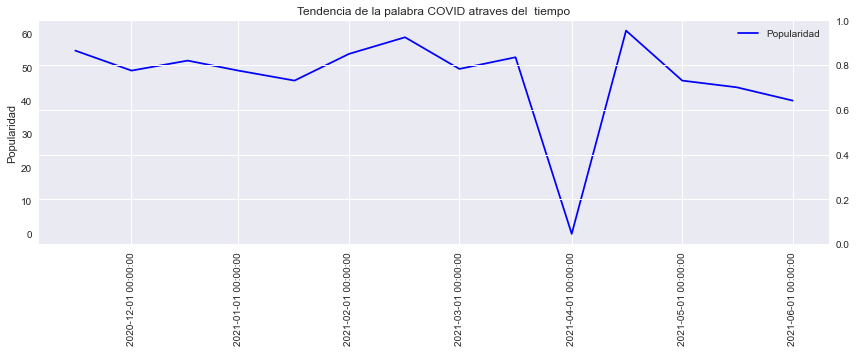

In [243]:
#### this function somethings return no data based on google network, in case of error you can re-run till 
find_trend( first_summary , "France" ) 

Para la mayoría de los ejemplos que se seleccionaron se puede observar la tendencia de que una vez que se inició aplicar las vacunas la mediana de nuevas muertes empezaron a desacelerar de manera más rápida, por lo que si se observó un comportamiento positivo, ahora en los tres casos también se comparte que en cierto punto ambas tendencias se mantienen un poco constante, para el caso de reino unido el crecimiento de nuevos casos es más grande que la de muertos, justo lo que se esperaba ya que la vacuna da cierto nivel de protección. sin embargo, para otros países el crecimiento tiene una pendiente casi igual para ambas tendencias.

Vale recalcar que lo que buscamos en un comportamiento de crecimiento, no se puede concluir que hubo más muertos aunque las gráficas lo muestre visualmente, esta es una técnica que nos ayuda analizar la aceleracion ya sea en crecimiento o decrecimiento.

Por otro lado se intento comparar el nivel de popularidad de la palabra COVID para los rangos de fecha analizado en cada unos de los ejemplos, visualmente no se ve una tendencia puntal en los tres casos se observa que hay una decaida casi al mismo tiempo que los casos empiezan a disminuir.

In [244]:
covid_europe

,location,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,life_expectancy,surface_area,population,employment_industry,internet_users,iso2
0,Austria,2020-02-25,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
1,Austria,2020-02-26,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
2,Austria,2020-02-27,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
3,Austria,2020-02-28,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
4,Austria,2020-02-29,9.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,81.54,83871.00,9006.00,25.00,87.50,AT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17019,United Kingdom,2022-01-24,15992837.00,95317.00,154042.00,54.00,598.00,17210.00,429972989.00,0.07,137474493.00,52252579.00,48224978.00,81.32,242495.00,67886.00,17.70,94.90,GB
17020,United Kingdom,2022-01-25,16087344.00,94507.00,154485.00,443.00,575.00,16608.00,431317684.00,0.07,137570759.00,52266515.00,48253766.00,81.32,242495.00,67886.00,17.70,94.90,GB
17021,United Kingdom,2022-01-26,16189420.00,102076.00,154831.00,346.00,561.00,16514.00,432822845.00,0.07,137671500.00,52281873.00,48284685.00,81.32,242495.00,67886.00,17.70,94.90,GB
17022,United Kingdom,2022-01-27,16286017.00,96597.00,155169.00,338.00,549.00,16149.00,0.00,0.00,137770110.00,52297579.00,48314633.00,81.32,242495.00,67886.00,17.70,94.90,GB


- Segun el inicio de aplicacion de vacunas mensual como se compara con los nuevos casos.